In [1]:
import jax.numpy as np
from jax import random, grad, jit, vmap
from functools import partial
key = random.PRNGKey(0)
from jax.experimental import optimizers
from NODE_ICNN_CANN_MF_fns import *
import matplotlib.pyplot as plt
import pickle
from jax.config import config
import pandas as pd
config.update("jax_enable_x64", True)
plt.rcParams.update({'font.size': 12})

/opt/homebrew/lib/python3.9/site-packages/jax/_src/lib/__init__.py:33: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "
/opt/homebrew/lib/python3.9/site-packages/jax/experimental/optimizers.py:28: FutureWarning: jax.experimental.optimizers is deprecated, import jax.example_libraries.optimizers instead
  warnings.warn('jax.experimental.optimizers is deprecated, '


# Train NODE, CANN, ICNN, MFNN, directly against rubber stress data

Train directly against the stress data from the three rubber datasets.
Note. I wanted to do these four different schemes. the last one I wanted to do was this MF scheme where I would combine a CANN with a NODE but that doesnt seem necessary in that the CANN and the NODE alone can do just fine for rubber data. So at least for rubber doesnt seem necessary. 

In [2]:
## Functions to calculate the stress from the prediction of
# strain energy derivatives from 'model' for three types of deformation
# i) Uniaxial, ii) Equibiaxial, iii) Pure-shear
# From Vahid's notebook, I do like the use of the 'model' class
# but adding normalization 
def P11_UT(lamb, model, normalization):
    I1_factor = normalization[0]
    I2_factor = normalization[1]
    Psi1_factor = normalization[2]
    Psi2_factor = normalization[3]
    I1 = lamb**2 + 2/lamb
    I2 = 2*lamb + 1/lamb**2
    I1norm = (I1-3)/I1_factor
    I2norm = (I2-3)/I2_factor
    Psi1 = model.Psi1norm(I1norm)*Psi1_factor
    Psi2 = model.Psi2norm(I2norm)*Psi2_factor
    return 2*(Psi1 + Psi2/lamb)*(lamb-1/lamb**2)
def P11_ET(lamb, model, normalization):
    I1_factor = normalization[0]
    I2_factor = normalization[1]
    Psi1_factor = normalization[2]
    Psi2_factor = normalization[3]
    I1 = 2*lamb**2 + 1/lamb**4
    I2 = lamb**4 + 2/lamb**2
    I1norm = (I1-3)/I1_factor
    I2norm = (I2-3)/I2_factor
    Psi1 = model.Psi1norm(I1norm)*Psi1_factor
    Psi2 = model.Psi2norm(I2norm)*Psi2_factor
    return 2*(Psi1 + Psi2*lamb**2)*(lamb-1/lamb**5)
def P11_PS(lamb, model, normalization):
    I1_factor = normalization[0]
    I2_factor = normalization[1]
    Psi1_factor = normalization[2]
    Psi2_factor = normalization[3]
    I1 =  lamb**2 + 1/lamb**2 + 1
    I2 =  lamb**2 + 1/lamb**2 + 1
    I1norm = (I1-3)/I1_factor
    I2norm = (I2-3)/I2_factor
    Psi1 = model.Psi1norm(I1norm)*Psi1_factor
    Psi2 = model.Psi2norm(I2norm)*Psi2_factor
    return 2*(Psi1+Psi2)*(lamb-1/lamb**3)

In [3]:
## Eval invariants for the three types of deformation
def evalI1_UT(lam):
    return lam**2 + (2/lam)
def evalI2_UT(lam):
    return 2*lam + (1/lam**2)

def evalI1_ET(lam):
    return 2*lam**2 +1/lam**4
def evalI2_ET(lam):
    return lam**4 + 2/lam**2

def evalI1_PS(lam):
    return lam**2 + 1/lam**2 + 1
def evalI2_PS(lam):
    return lam**2 + 1/lam**2 + 1

In [4]:
# read the data
UTdata = pd.read_csv('Data/UT20.csv')
ETdata = pd.read_csv('Data/ET20.csv')
PSdata = pd.read_csv('Data/PS20.csv')
# stack into single array 
P11_data = np.hstack([UTdata['P11'].to_numpy(),ETdata['P11'].to_numpy(),PSdata['P11'].to_numpy()])
F11_data = np.hstack([UTdata['F11'].to_numpy(),ETdata['F11'].to_numpy(),PSdata['F11'].to_numpy()])
# indices for the three data sets
indET = len(UTdata['P11'])
indPS = indET + len(ETdata['P11'])

## NODE fits

### Fit all three tests at the same time

In [5]:
## NODE model outputs normalized strain energy given normalized invariants
class NODE_model():
    def __init__(self, params_I1, params_I2):
        self.params_I1 = params_I1
        self.params_I2 = params_I2
    def Psi1norm(self, I1norm):
        # Note: I1norm = (I1-3)/normalization
        return NODE_vmap(I1norm, self.params_I1)
    def Psi2norm(self, I2norm):
        # Note: I2norm = (I2-3)/normalization
        return NODE_vmap(I2norm, self.params_I2)

In [6]:
I1_factor = 30
Psi1_factor = 0.3
I2_factor = 250
Psi2_factor = 0.001
normalization = [I1_factor,I2_factor,Psi1_factor,Psi2_factor ]

@jit
def loss_P11_all(params, F11_data):
    lamUT = F11_data[0:indET]
    lamET = F11_data[indET:indPS]
    lamPS = F11_data[indPS:]
    params_I1 = params[0]
    params_I2 = params[1]
    #model = NODE_model(params_I1,params_I2)
    #model = ICNN_model(params_I1,params_I2,normalization)
    #model = CANN_model(params_I1,params_I2,normalization)
    P11UT_pr = P11_UT(lamUT, model, normalization)
    P11ET_pr = P11_ET(lamET, model, normalization)
    P11PS_pr = P11_PS(lamPS, model, normalization)    
    return np.mean((P11UT_pr-P11_data[0:indET])**2)+np.mean((P11ET_pr-P11_data[indET:indPS])**2)+np.mean((P11PS_pr-P11_data[indPS:])**2)

@jit
def loss_P11_UT(params, F11_data):
    lamUT = F11_data[0:indET]
    params_I1 = params[0]
    params_I2 = params[1]
    #model = NODE_model(params_I1,params_I2)
    #model = ICNN_model(params_I1,params_I2,normalization)
    #model = CANN_model(params_I1,params_I2,normalization)
    P11UT_pr = P11_UT(lamUT, model, normalization)
    return np.mean((P11UT_pr-P11_data[0:indET])**2)

@jit
def loss_P11_ET(params, F11_data):
    lamET = F11_data[indET:indPS]
    params_I1 = params[0]
    params_I2 = params[1]
    #model = NODE_model(params_I1,params_I2)
    #model = ICNN_model(params_I1,params_I2,normalization)
    #model = CANN_model(params_I1,params_I2,normalization)
    P11ET_pr = P11_ET(lamET, model, normalization)
    return np.mean((P11ET_pr-P11_data[indET:indPS])**2)

@jit
def loss_P11_PS(params, F11_data):
    lamPS = F11_data[indPS:]
    params_I1 = params[0]
    params_I2 = params[1]
    #model = NODE_model(params_I1,params_I2)
    #model = ICNN_model(params_I1,params_I2,normalization)
    model = CANN_model(params_I1,params_I2,normalization)
    P11PS_pr = P11_PS(lamPS, model, normalization)    
    return np.mean((P11PS_pr-P11_data[indPS:])**2)


@partial(jit, static_argnums=(0,))
def step_jp(loss, i, opt_state, X_batch):
    params = get_params(opt_state)
    g = grad(loss)(params, X_batch)
    return opt_update(i, g, opt_state)

def train_jp(loss, X, opt_state, key, nIter = 10000):
    train_loss = []
    val_loss = []
    for it in range(nIter):
        opt_state = step_jp(loss, it, opt_state, X)         
        if (it+1)% 1000 == 0:
            params = get_params(opt_state)
            train_loss_value = loss(params, X)
            train_loss.append(train_loss_value)
            to_print = "it %i, train loss = %e" % (it+1, train_loss_value)
            print(to_print)
    return get_params(opt_state), train_loss, val_loss


In [10]:
layers = [1, 5, 5, 1]
params_I1 = init_params(layers, key)
params_I2 = init_params(layers, key)
params_all = [params_I1,params_I2]
opt_init, opt_update, get_params = optimizers.adam(2.e-4) #Original: 1.e-4
opt_state = opt_init(params_all)
params_all, train_loss, val_loss = train_jp(loss_P11_all, F11_data, opt_state, key, nIter = 50000) #Original 100000

it 1000, train loss = 7.098134e-01
it 2000, train loss = 5.731273e-01
it 3000, train loss = 5.085727e-01
it 4000, train loss = 4.771594e-01
it 5000, train loss = 4.652303e-01
it 6000, train loss = 4.594757e-01
it 7000, train loss = 4.559229e-01
it 8000, train loss = 4.534073e-01
it 9000, train loss = 4.515594e-01
it 10000, train loss = 4.501053e-01
it 11000, train loss = 4.122727e-01
it 12000, train loss = 3.216752e-01
it 13000, train loss = 1.441537e-01
it 14000, train loss = 5.066995e-02
it 15000, train loss = 2.537729e-02
it 16000, train loss = 1.894414e-02
it 17000, train loss = 1.736296e-02
it 18000, train loss = 1.653811e-02
it 19000, train loss = 1.568400e-02
it 20000, train loss = 1.457730e-02
it 21000, train loss = 1.337659e-02
it 22000, train loss = 1.221044e-02
it 23000, train loss = 1.139314e-02
it 24000, train loss = 1.084606e-02
it 25000, train loss = 1.043757e-02
it 26000, train loss = 1.011285e-02
it 27000, train loss = 9.844635e-03
it 28000, train loss = 9.620535e-03
i

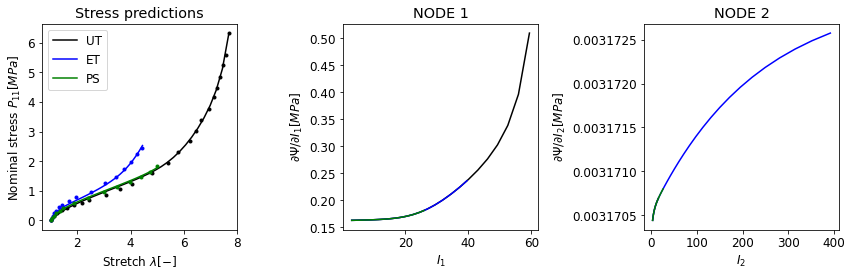

In [12]:
fig,axs = plt.subplots(1,3,figsize=(12,4))

lamUT_vec = np.linspace(1,UTdata['F11'].iloc[-1],30)
lamET_vec = np.linspace(1,ETdata['F11'].iloc[-1],30)
lamPS_vec = np.linspace(1,PSdata['F11'].iloc[-1],30)

normalization = [I1_factor,I2_factor,Psi1_factor,Psi2_factor ]
model = NODE_model(params_all[0], params_all[1])
P11_NN_UT = P11_UT(lamUT_vec, model, normalization)
P11_NN_ET = P11_ET(lamET_vec, model, normalization)
P11_NN_PS = P11_PS(lamPS_vec, model, normalization) 

axs[0].plot(UTdata['F11'],UTdata['P11'] , 'k.')
axs[0].plot(lamUT_vec, P11_NN_UT, 'k',label='UT')

axs[0].plot(ETdata['F11'],ETdata['P11'] , 'b.')
axs[0].plot(lamET_vec, P11_NN_ET, 'b',label='ET')

axs[0].plot(PSdata['F11'],PSdata['P11'] , 'g.')
axs[0].plot(lamPS_vec, P11_NN_PS, 'g',label='PS')
axs[0].legend(loc=2)
axs[0].set_title('Stress predictions')
axs[0].set_xlabel(r'Stretch $\lambda [-]$')
axs[0].set_ylabel(r'Nominal stress $P_{11} [MPa]$')

I1_vec = evalI1_UT(lamUT_vec)
I2_vec = evalI2_UT(lamUT_vec)
axs[1].plot(I1_vec,model.Psi1norm(I1_vec/I1_factor)*Psi1_factor,'k')
axs[2].plot(I2_vec,model.Psi2norm(I2_vec/I2_factor)*Psi2_factor,'k')

I1_vec = evalI1_ET(lamET_vec)
I2_vec = evalI2_ET(lamET_vec)
axs[1].plot(I1_vec,model.Psi1norm(I1_vec/I1_factor)*Psi1_factor,'b')
axs[2].plot(I2_vec,model.Psi2norm(I2_vec/I2_factor)*Psi2_factor,'b')

I1_vec = evalI1_PS(lamPS_vec)
I2_vec = evalI2_PS(lamPS_vec)
axs[1].plot(I1_vec,model.Psi1norm(I1_vec/I1_factor)*Psi1_factor,'g')
axs[2].plot(I2_vec,model.Psi2norm(I2_vec/I2_factor)*Psi2_factor,'g')

axs[1].set_title('NODE 1')
axs[2].set_title('NODE 2')
axs[1].set_xlabel(r'$I_1$')
axs[2].set_xlabel(r'$I_2$')
axs[1].set_ylabel(r'$\partial \Psi/\partial I_1 [MPa]$')
axs[2].set_ylabel(r'$\partial \Psi/\partial I_2 [MPa]$')


plt.tight_layout()
#plt.savefig('NODE.png',dpi=200)

In [13]:
## Let's finish with the error
lamUT = F11_data[0:indET]
lamET = F11_data[indET:indPS]
lamPS = F11_data[indPS:]
errorNODE_UT = np.mean(np.abs(P11_UT(lamUT, model, normalization)-UTdata['P11'].to_numpy()))
errorNODE_ET = np.mean(np.abs(P11_ET(lamET, model, normalization)-ETdata['P11'].to_numpy()))
errorNODE_PS = np.mean(np.abs(P11_PS(lamPS, model, normalization)-PSdata['P11'].to_numpy()))
errorNODE = 1/3*(errorNODE_UT+errorNODE_ET+errorNODE_PS)
print('MAE NODE')
print(errorNODE)

MAE NODE
0.04099899000545624


In [30]:
# save the result with pickle
with open('NODE_params_all.npy', 'wb') as f:
    pickle.dump(params_all, f)

In [6]:
# check by reading pickle 
with open('NODE_params_all.npy', 'rb') as f:
    params_all = pickle.load(f)
#print(param_read)
#print(params_all)

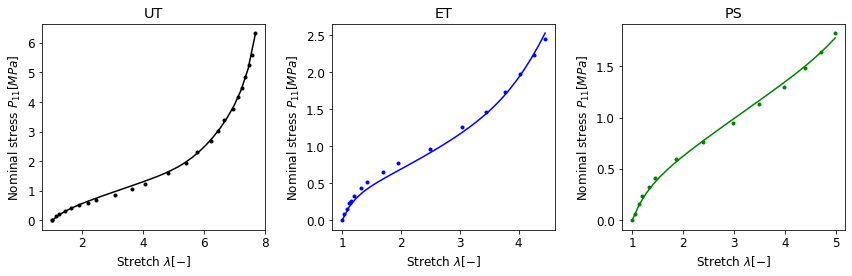

In [16]:
## Generate the output of all 3 tests
fig,axs = plt.subplots(1,3,figsize=(12,4))

lamUT_vec = np.linspace(1,UTdata['F11'].iloc[-1],30)
lamET_vec = np.linspace(1,ETdata['F11'].iloc[-1],30)
lamPS_vec = np.linspace(1,PSdata['F11'].iloc[-1],30)

normalization = [I1_factor,I2_factor,Psi1_factor,Psi2_factor ]
model = NODE_model(params_all[0], params_all[1])
P11_NN_UT_u = P11_UT(lamUT_vec, model, normalization)
P11_NN_ET_u = P11_ET(lamET_vec, model, normalization)
P11_NN_PS_u = P11_PS(lamPS_vec, model, normalization) 

axs[0].plot(UTdata['F11'],UTdata['P11'] , 'k.')
axs[0].plot(lamUT_vec, P11_NN_UT_u, 'k',label='UT')

axs[1].plot(ETdata['F11'],ETdata['P11'] , 'b.')
axs[1].plot(lamET_vec, P11_NN_ET_u, 'b',label='ET')

axs[2].plot(PSdata['F11'],PSdata['P11'] , 'g.')
axs[2].plot(lamPS_vec, P11_NN_PS_u, 'g',label='PS')

#axs[0].legend(loc=2)
axs[0].set_title('UT')
axs[0].set_xlabel(r'Stretch $\lambda [-]$')
axs[0].set_ylabel(r'Nominal stress $P_{11} [MPa]$')

axs[1].set_title('ET')
axs[1].set_xlabel(r'Stretch $\lambda [-]$')
axs[1].set_ylabel(r'Nominal stress $P_{11} [MPa]$')

axs[2].set_title('PS')
axs[2].set_xlabel(r'Stretch $\lambda [-]$')
axs[2].set_ylabel(r'Nominal stress $P_{11} [MPa]$')

plt.tight_layout()

### NODE training with one set of data and comparing to the others 

In [22]:
# train with uniaxial only
params_I1 = init_params(layers, key)
params_I2 = init_params(layers, key)
params_UT = [params_I1,params_I2]
opt_init, opt_update, get_params = optimizers.adam(5.e-4) #Original: 1.e-4
opt_state = opt_init(params_UT)
params_UT, train_loss, val_loss = train_jp(loss_P11_UT, F11_data, opt_state, key, nIter = 100000) #Original 100000

it 1000, train loss = 2.346495e-01
it 2000, train loss = 1.486733e-01
it 3000, train loss = 1.390876e-01
it 4000, train loss = 1.320384e-01
it 5000, train loss = 1.278539e-01
it 6000, train loss = 1.255094e-01
it 7000, train loss = 1.231421e-01
it 8000, train loss = 1.220889e-01
it 9000, train loss = 1.213436e-01
it 10000, train loss = 1.206979e-01
it 11000, train loss = 1.200824e-01
it 12000, train loss = 1.194774e-01
it 13000, train loss = 1.188807e-01
it 14000, train loss = 1.182911e-01
it 15000, train loss = 1.177041e-01
it 16000, train loss = 1.171163e-01
it 17000, train loss = 1.165281e-01
it 18000, train loss = 1.159422e-01
it 19000, train loss = 1.153624e-01
it 20000, train loss = 1.147883e-01
it 21000, train loss = 1.142189e-01
it 22000, train loss = 1.136533e-01
it 23000, train loss = 1.130753e-01
it 24000, train loss = 1.123652e-01
it 25000, train loss = 1.117032e-01
it 26000, train loss = 1.110534e-01
it 27000, train loss = 1.104057e-01
it 28000, train loss = 1.097462e-01
i

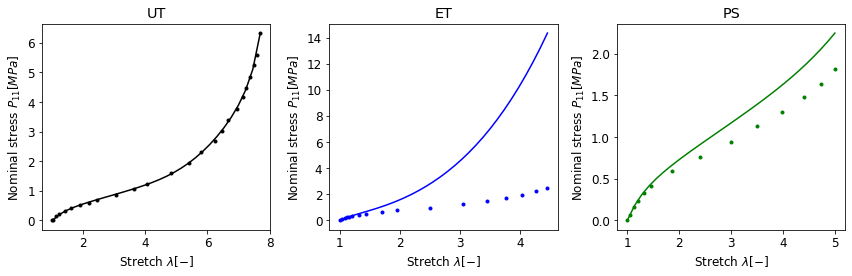

In [23]:
## Generate the output of all 3 tests
fig,axs = plt.subplots(1,3,figsize=(12,4))

lamUT_vec = np.linspace(1,UTdata['F11'].iloc[-1],30)
lamET_vec = np.linspace(1,ETdata['F11'].iloc[-1],30)
lamPS_vec = np.linspace(1,PSdata['F11'].iloc[-1],30)

normalization = [I1_factor,I2_factor,Psi1_factor,Psi2_factor ]
model = NODE_model(params_UT[0], params_UT[1])
P11_NN_UT_u = P11_UT(lamUT_vec, model, normalization)
P11_NN_ET_u = P11_ET(lamET_vec, model, normalization)
P11_NN_PS_u = P11_PS(lamPS_vec, model, normalization) 

axs[0].plot(UTdata['F11'],UTdata['P11'] , 'k.')
axs[0].plot(lamUT_vec, P11_NN_UT_u, 'k',label='UT')

axs[1].plot(ETdata['F11'],ETdata['P11'] , 'b.')
axs[1].plot(lamET_vec, P11_NN_ET_u, 'b',label='ET')

axs[2].plot(PSdata['F11'],PSdata['P11'] , 'g.')
axs[2].plot(lamPS_vec, P11_NN_PS_u, 'g',label='PS')

#axs[0].legend(loc=2)
axs[0].set_title('UT')
axs[0].set_xlabel(r'Stretch $\lambda [-]$')
axs[0].set_ylabel(r'Nominal stress $P_{11} [MPa]$')

axs[1].set_title('ET')
axs[1].set_xlabel(r'Stretch $\lambda [-]$')
axs[1].set_ylabel(r'Nominal stress $P_{11} [MPa]$')

axs[2].set_title('PS')
axs[2].set_xlabel(r'Stretch $\lambda [-]$')
axs[2].set_ylabel(r'Nominal stress $P_{11} [MPa]$')

# I1_vec = evalI1_UT(lamUT_vec)
# I2_vec = evalI2_UT(lamUT_vec)
# axs[1].plot(I1_vec,model.Psi1norm(I1_vec/I1_factor)*Psi1_factor,'k')
# axs[2].plot(I2_vec,model.Psi2norm(I2_vec/I2_factor)*Psi2_factor,'k')

# I1_vec = evalI1_ET(lamET_vec)
# I2_vec = evalI2_ET(lamET_vec)
# axs[1].plot(I1_vec,model.Psi1norm(I1_vec/I1_factor)*Psi1_factor,'b')
# axs[2].plot(I2_vec,model.Psi2norm(I2_vec/I2_factor)*Psi2_factor,'b')

# I1_vec = evalI1_PS(lamPS_vec)
# I2_vec = evalI2_PS(lamPS_vec)
# axs[1].plot(I1_vec,model.Psi1norm(I1_vec/I1_factor)*Psi1_factor,'g')
# axs[2].plot(I2_vec,model.Psi2norm(I2_vec/I2_factor)*Psi2_factor,'g')

# axs[1].set_title('NODE 1')
# axs[2].set_title('NODE 2')
# axs[1].set_xlabel(r'$I_1$')
# axs[2].set_xlabel(r'$I_2$')
# axs[1].set_ylabel(r'$\partial \Psi/\partial I_1 [MPa]$')
# axs[2].set_ylabel(r'$\partial \Psi/\partial I_2 [MPa]$')
plt.tight_layout()
#plt.savefig('NODE_UT_ri.png',dpi=200)

In [24]:
# save the result with pickle
with open('NODE_params_UT.npy', 'wb') as f:
    pickle.dump(params_UT, f)

In [25]:
# train with equibiaxial only, 
params_I1 = init_params(layers, key)
params_I2 = init_params(layers, key)
params_ET = [params_I1,params_I2]
opt_init, opt_update, get_params = optimizers.adam(2.e-4) #Original: 1.e-4
opt_state = opt_init(params_ET)
params_ET, train_loss, val_loss = train_jp(loss_P11_ET, F11_data, opt_state, key, nIter = 100000) #Original 100000

it 1000, train loss = 1.452788e-01
it 2000, train loss = 1.363137e-01
it 3000, train loss = 1.300489e-01
it 4000, train loss = 1.278987e-01
it 5000, train loss = 1.271875e-01
it 6000, train loss = 1.268630e-01
it 7000, train loss = 1.266382e-01
it 8000, train loss = 1.252617e-01
it 9000, train loss = 8.653260e-02
it 10000, train loss = 4.102064e-02
it 11000, train loss = 1.769028e-02
it 12000, train loss = 6.953203e-03
it 13000, train loss = 2.863674e-03
it 14000, train loss = 1.569593e-03
it 15000, train loss = 9.390428e-04
it 16000, train loss = 5.709475e-04
it 17000, train loss = 3.489240e-04
it 18000, train loss = 2.304226e-04
it 19000, train loss = 1.770365e-04
it 20000, train loss = 1.494632e-04
it 21000, train loss = 1.312865e-04
it 22000, train loss = 1.184747e-04
it 23000, train loss = 1.107492e-04
it 24000, train loss = 1.064526e-04
it 25000, train loss = 1.040454e-04
it 26000, train loss = 1.026501e-04
it 27000, train loss = 1.018026e-04
it 28000, train loss = 1.012605e-04
i

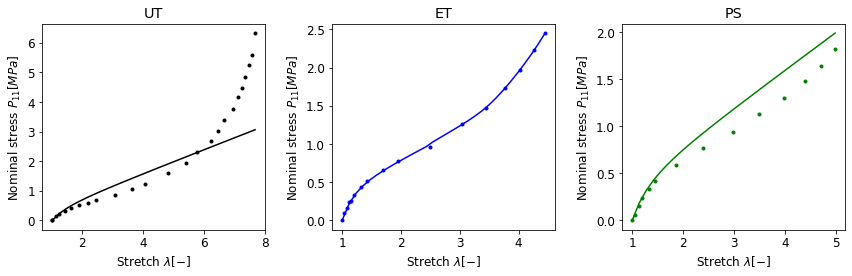

In [26]:
## Generate the output of all 3 tests
fig,axs = plt.subplots(1,3,figsize=(12,4))

lamUT_vec = np.linspace(1,UTdata['F11'].iloc[-1],30)
lamET_vec = np.linspace(1,ETdata['F11'].iloc[-1],30)
lamPS_vec = np.linspace(1,PSdata['F11'].iloc[-1],30)

normalization = [I1_factor,I2_factor,Psi1_factor,Psi2_factor ]
model = NODE_model(params_ET[0], params_ET[1])
P11_NN_UT_e = P11_UT(lamUT_vec, model, normalization)
P11_NN_ET_e = P11_ET(lamET_vec, model, normalization)
P11_NN_PS_e = P11_PS(lamPS_vec, model, normalization) 

axs[0].plot(UTdata['F11'],UTdata['P11'] , 'k.')
axs[0].plot(lamUT_vec, P11_NN_UT_e, 'k',label='UT')

axs[1].plot(ETdata['F11'],ETdata['P11'] , 'b.')
axs[1].plot(lamET_vec, P11_NN_ET_e, 'b',label='ET')

axs[2].plot(PSdata['F11'],PSdata['P11'] , 'g.')
axs[2].plot(lamPS_vec, P11_NN_PS_e, 'g',label='PS')

#axs[0].legend(loc=2)
axs[0].set_title('UT')
axs[0].set_xlabel(r'Stretch $\lambda [-]$')
axs[0].set_ylabel(r'Nominal stress $P_{11} [MPa]$')

axs[1].set_title('ET')
axs[1].set_xlabel(r'Stretch $\lambda [-]$')
axs[1].set_ylabel(r'Nominal stress $P_{11} [MPa]$')

axs[2].set_title('PS')
axs[2].set_xlabel(r'Stretch $\lambda [-]$')
axs[2].set_ylabel(r'Nominal stress $P_{11} [MPa]$')
plt.tight_layout()
#plt.savefig('NODE_ET_ri.png',dpi=200)

In [27]:
# save the result with pickle
with open('NODE_params_ET.npy', 'wb') as f:
    pickle.dump(params_ET, f)

In [28]:
# train with pure shear only, 
params_I1 = init_params(layers, key)
params_I2 = init_params(layers, key)
params_PS = [params_I1,params_I2]
opt_init, opt_update, get_params = optimizers.adam(2.e-4) #Original: 1.e-4
opt_state = opt_init(params_PS)
params_PS, train_loss, val_loss = train_jp(loss_P11_PS, F11_data, opt_state, key, nIter = 100000) #Original 100000

it 1000, train loss = 1.232893e-01
it 2000, train loss = 1.206581e-01
it 3000, train loss = 8.698582e-02
it 4000, train loss = 4.425626e-02
it 5000, train loss = 2.302167e-02
it 6000, train loss = 1.056799e-02
it 7000, train loss = 4.351821e-03
it 8000, train loss = 2.774906e-03
it 9000, train loss = 2.336599e-03
it 10000, train loss = 2.153122e-03
it 11000, train loss = 2.047202e-03
it 12000, train loss = 1.985691e-03
it 13000, train loss = 1.861481e-03
it 14000, train loss = 1.032874e-03
it 15000, train loss = 8.292999e-04
it 16000, train loss = 7.147148e-04
it 17000, train loss = 6.465831e-04
it 18000, train loss = 6.033322e-04
it 19000, train loss = 5.758064e-04
it 20000, train loss = 5.583681e-04
it 21000, train loss = 5.472604e-04
it 22000, train loss = 5.399239e-04
it 23000, train loss = 5.348147e-04
it 24000, train loss = 5.310742e-04
it 25000, train loss = 5.282394e-04
it 26000, train loss = 5.259807e-04
it 27000, train loss = 5.240686e-04
it 28000, train loss = 5.223647e-04
i

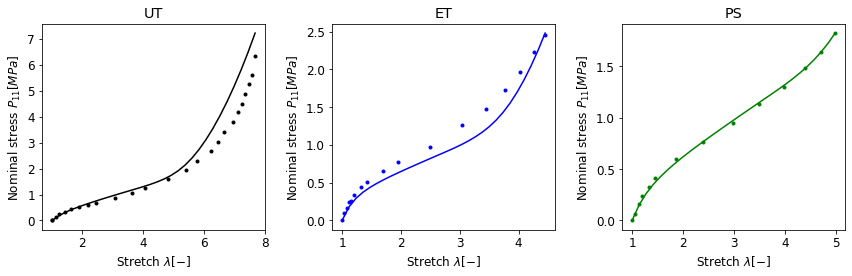

In [29]:
## Generate the output of all 3 tests
fig,axs = plt.subplots(1,3,figsize=(12,4))

lamUT_vec = np.linspace(1,UTdata['F11'].iloc[-1],30)
lamET_vec = np.linspace(1,ETdata['F11'].iloc[-1],30)
lamPS_vec = np.linspace(1,PSdata['F11'].iloc[-1],30)

normalization = [I1_factor,I2_factor,Psi1_factor,Psi2_factor ]
model = NODE_model(params_PS[0], params_PS[1])
P11_NN_UT_p = P11_UT(lamUT_vec, model, normalization)
P11_NN_ET_p = P11_ET(lamET_vec, model, normalization)
P11_NN_PS_p = P11_PS(lamPS_vec, model, normalization) 

axs[0].plot(UTdata['F11'],UTdata['P11'] , 'k.')
axs[0].plot(lamUT_vec, P11_NN_UT_p, 'k',label='UT')

axs[1].plot(ETdata['F11'],ETdata['P11'] , 'b.')
axs[1].plot(lamET_vec, P11_NN_ET_p, 'b',label='ET')

axs[2].plot(PSdata['F11'],PSdata['P11'] , 'g.')
axs[2].plot(lamPS_vec, P11_NN_PS_p, 'g',label='PS')

#axs[0].legend(loc=2)
axs[0].set_title('UT')
axs[0].set_xlabel(r'Stretch $\lambda [-]$')
axs[0].set_ylabel(r'Nominal stress $P_{11} [MPa]$')

axs[1].set_title('ET')
axs[1].set_xlabel(r'Stretch $\lambda [-]$')
axs[1].set_ylabel(r'Nominal stress $P_{11} [MPa]$')

axs[2].set_title('PS')
axs[2].set_xlabel(r'Stretch $\lambda [-]$')
axs[2].set_ylabel(r'Nominal stress $P_{11} [MPa]$')
plt.tight_layout()
#plt.savefig('NODE_PS_ri.png',dpi=200)

In [30]:
# save the result with pickle
with open('NODE_params_PS.npy', 'wb') as f:
    pickle.dump(params_PS, f)

## Train ICNN model

In [7]:
# play with ICNN a bit, how do we get that one to work
class ICNN_model():
    def __init__(self, params_I1, params_I2,normalization):
        self.params_I1 = params_I1
        self.params_I2 = params_I2
        self.normalization = normalization
    # Psi1
    # note: for ICNN the prediction is the function not the gradient
    # but the P11_UT, P11_ET, etc expects the model to output the derivative
    def Psi1norm(self, I1norm):
        # Note: I1norm = (I1-3)/normalization
        f1 = lambda x: icnn_forwardpass(x, self.params_I1)[0]
        #normalization = [I1_factor,I2_factor,Psi1_factor,Psi2_factor ]
        df1 = grad(f1)
        return vmap(df1)(I1norm[:,None])[:,0]/self.normalization[0]
    # Psi2
    # note: for ICNN the prediction is the function not the gradient
    def Psi2norm(self, I2norm):
        # Note: I2norm = (I2-3)/normalization
        f2 = lambda x: icnn_forwardpass(x, self.params_I2)[0]
        #normalization = [I1_factor,I2_factor,Psi1_factor,Psi2_factor ]
        df2 = grad(f2)
        return vmap(df2)(I2norm[:,None])[:,0]/self.normalization[1]

In [94]:
## check the model gives what it should
layers = [1, 5, 5, 1]
params_icnn_I1 = init_params_icnn(layers, key)
params_icnn_I2 = init_params_icnn(layers, key)
model_icnn = ICNN_model(params_icnn_I1,params_icnn_I2,normalization)
check1_icnn = model_icnn.Psi1norm(np.linspace(0,1,10))
check2_icnn = model_icnn.Psi1norm(np.linspace(0,1,10))
print(check1_icnn)
#print(check2_icnn)
# compare against what the NODE would give you
params_node_I1 = init_params(layers, key)
params_node_I2 = init_params(layers, key)
model_node = NODE_model(params_node_I1,params_node_I2)
check1_node = model_node.Psi1norm(np.linspace(0,1,10))
check2_node = model_node.Psi1norm(np.linspace(0,1,10))
print(check1_node)


[-0.0160857  -0.01603842 -0.01599136 -0.01594467 -0.01589848 -0.01585294
 -0.01580817 -0.01576427 -0.01572133 -0.01567945]
[0.         0.12643964 0.25193243 0.37577179 0.4976011  0.61737672
 0.73525866 0.85150263 0.96638578 1.08016679]


In [98]:
layers = [1, 5, 5, 1]
params_I1 = init_params_icnn(layers, key)
params_I2 = init_params_icnn(layers, key)
params_icnn_all = [params_I1,params_I2]
opt_init, opt_update, get_params = optimizers.adam(2.e-4) #Original: 1.e-4
opt_state = opt_init(params_icnn_all)
params_icnn_all, train_loss, val_loss = train_jp(loss_P11_all, F11_data, opt_state, key, nIter = 50000) #Original 100000

it 1000, train loss = 1.128215e+01
it 2000, train loss = 1.095927e+01
it 3000, train loss = 1.046063e+01
it 4000, train loss = 9.672822e+00
it 5000, train loss = 8.409191e+00
it 6000, train loss = 6.448558e+00
it 7000, train loss = 3.841996e+00
it 8000, train loss = 1.572956e+00
it 9000, train loss = 8.776985e-01
it 10000, train loss = 8.270163e-01
it 11000, train loss = 7.970900e-01
it 12000, train loss = 7.623023e-01
it 13000, train loss = 7.191805e-01
it 14000, train loss = 6.640646e-01
it 15000, train loss = 5.938442e-01
it 16000, train loss = 5.089366e-01
it 17000, train loss = 4.164929e-01
it 18000, train loss = 3.274530e-01
it 19000, train loss = 2.522096e-01
it 20000, train loss = 1.969884e-01
it 21000, train loss = 1.608249e-01
it 22000, train loss = 1.361511e-01
it 23000, train loss = 1.162836e-01
it 24000, train loss = 9.725316e-02
it 25000, train loss = 7.597776e-02
it 26000, train loss = 5.301190e-02
it 27000, train loss = 3.212411e-02
it 28000, train loss = 1.898236e-02
i

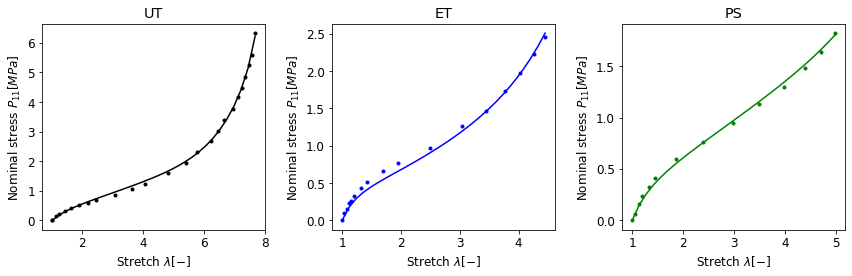

In [99]:
## Generate the output of all 3 tests
fig,axs = plt.subplots(1,3,figsize=(12,4))

lamUT_vec = np.linspace(1,UTdata['F11'].iloc[-1],30)
lamET_vec = np.linspace(1,ETdata['F11'].iloc[-1],30)
lamPS_vec = np.linspace(1,PSdata['F11'].iloc[-1],30)

normalization = [I1_factor,I2_factor,Psi1_factor,Psi2_factor ]
model = ICNN_model(params_icnn_all[0], params_icnn_all[1], normalization)
P11_NN_UT_p = P11_UT(lamUT_vec, model, normalization)
P11_NN_ET_p = P11_ET(lamET_vec, model, normalization)
P11_NN_PS_p = P11_PS(lamPS_vec, model, normalization) 

axs[0].plot(UTdata['F11'],UTdata['P11'] , 'k.')
axs[0].plot(lamUT_vec, P11_NN_UT_p, 'k',label='UT')

axs[1].plot(ETdata['F11'],ETdata['P11'] , 'b.')
axs[1].plot(lamET_vec, P11_NN_ET_p, 'b',label='ET')

axs[2].plot(PSdata['F11'],PSdata['P11'] , 'g.')
axs[2].plot(lamPS_vec, P11_NN_PS_p, 'g',label='PS')

#axs[0].legend(loc=2)
axs[0].set_title('UT')
axs[0].set_xlabel(r'Stretch $\lambda [-]$')
axs[0].set_ylabel(r'Nominal stress $P_{11} [MPa]$')

axs[1].set_title('ET')
axs[1].set_xlabel(r'Stretch $\lambda [-]$')
axs[1].set_ylabel(r'Nominal stress $P_{11} [MPa]$')

axs[2].set_title('PS')
axs[2].set_xlabel(r'Stretch $\lambda [-]$')
axs[2].set_ylabel(r'Nominal stress $P_{11} [MPa]$')
plt.tight_layout()

In [100]:
# save the result with pickle
with open('ICNN_params_all.npy', 'wb') as f:
    pickle.dump(params_icnn_all, f)

In [9]:
# train with uniaxial only
layers = [1, 5, 5, 1]
params_I1 = init_params_icnn(layers, key)
params_I2 = init_params_icnn(layers, key)
params_icnn_UT = [params_I1,params_I2]
opt_init, opt_update, get_params = optimizers.adam(2.e-4) #Original: 1.e-4
opt_state = opt_init(params_icnn_UT)
params_icnn_UT, train_loss, val_loss = train_jp(loss_P11_UT, F11_data, opt_state, key, nIter = 100000) #Original 100000

it 1000, train loss = 8.852674e+00
it 2000, train loss = 8.618306e+00
it 3000, train loss = 8.257435e+00
it 4000, train loss = 7.689632e+00
it 5000, train loss = 6.777354e+00
it 6000, train loss = 5.343956e+00
it 7000, train loss = 3.356328e+00
it 8000, train loss = 1.409041e+00
it 9000, train loss = 6.146975e-01
it 10000, train loss = 5.527321e-01
it 11000, train loss = 5.366137e-01
it 12000, train loss = 5.187298e-01
it 13000, train loss = 4.975348e-01
it 14000, train loss = 4.714695e-01
it 15000, train loss = 4.381084e-01
it 16000, train loss = 3.945494e-01
it 17000, train loss = 3.404943e-01
it 18000, train loss = 2.804260e-01
it 19000, train loss = 2.208170e-01
it 20000, train loss = 1.666310e-01
it 21000, train loss = 1.212893e-01
it 22000, train loss = 9.353014e-02
it 23000, train loss = 7.811248e-02
it 24000, train loss = 6.791674e-02
it 25000, train loss = 5.862434e-02
it 26000, train loss = 4.564263e-02
it 27000, train loss = 2.850645e-02
it 28000, train loss = 1.320119e-02
i

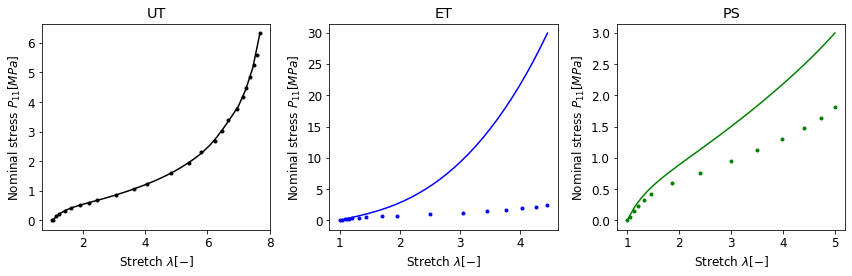

In [10]:
## Generate the output of all 3 tests
fig,axs = plt.subplots(1,3,figsize=(12,4))

lamUT_vec = np.linspace(1,UTdata['F11'].iloc[-1],30)
lamET_vec = np.linspace(1,ETdata['F11'].iloc[-1],30)
lamPS_vec = np.linspace(1,PSdata['F11'].iloc[-1],30)

normalization = [I1_factor,I2_factor,Psi1_factor,Psi2_factor ]
model = ICNN_model(params_icnn_UT[0], params_icnn_UT[1], normalization)
P11_NN_UT_p = P11_UT(lamUT_vec, model, normalization)
P11_NN_ET_p = P11_ET(lamET_vec, model, normalization)
P11_NN_PS_p = P11_PS(lamPS_vec, model, normalization) 

axs[0].plot(UTdata['F11'],UTdata['P11'] , 'k.')
axs[0].plot(lamUT_vec, P11_NN_UT_p, 'k',label='UT')

axs[1].plot(ETdata['F11'],ETdata['P11'] , 'b.')
axs[1].plot(lamET_vec, P11_NN_ET_p, 'b',label='ET')

axs[2].plot(PSdata['F11'],PSdata['P11'] , 'g.')
axs[2].plot(lamPS_vec, P11_NN_PS_p, 'g',label='PS')

#axs[0].legend(loc=2)
axs[0].set_title('UT')
axs[0].set_xlabel(r'Stretch $\lambda [-]$')
axs[0].set_ylabel(r'Nominal stress $P_{11} [MPa]$')

axs[1].set_title('ET')
axs[1].set_xlabel(r'Stretch $\lambda [-]$')
axs[1].set_ylabel(r'Nominal stress $P_{11} [MPa]$')

axs[2].set_title('PS')
axs[2].set_xlabel(r'Stretch $\lambda [-]$')
axs[2].set_ylabel(r'Nominal stress $P_{11} [MPa]$')
plt.tight_layout()

In [11]:
# save the result with pickle
with open('ICNN_params_UT.npy', 'wb') as f:
    pickle.dump(params_icnn_UT, f)

In [13]:
# train with equibiaxial only
layers = [1, 5, 5, 1]
params_I1 = init_params_icnn(layers, key)
params_I2 = init_params_icnn(layers, key)
params_icnn_ET = [params_I1,params_I2]
opt_init, opt_update, get_params = optimizers.adam(2.e-4) #Original: 1.e-4
opt_state = opt_init(params_icnn_ET)
params_icnn_ET, train_loss, val_loss = train_jp(loss_P11_ET, F11_data, opt_state, key, nIter = 100000) #Original 100000

it 1000, train loss = 1.452197e+00
it 2000, train loss = 1.405632e+00
it 3000, train loss = 1.333091e+00
it 4000, train loss = 1.217478e+00
it 5000, train loss = 1.033529e+00
it 6000, train loss = 7.529426e-01
it 7000, train loss = 3.897087e-01
it 8000, train loss = 9.275491e-02
it 9000, train loss = 1.579315e-02
it 10000, train loss = 1.355958e-02
it 11000, train loss = 1.283753e-02
it 12000, train loss = 1.177960e-02
it 13000, train loss = 1.033016e-02
it 14000, train loss = 8.491094e-03
it 15000, train loss = 6.442805e-03
it 16000, train loss = 4.689697e-03
it 17000, train loss = 3.735442e-03
it 18000, train loss = 3.199349e-03
it 19000, train loss = 2.661934e-03
it 20000, train loss = 2.107514e-03
it 21000, train loss = 1.577844e-03
it 22000, train loss = 1.112329e-03
it 23000, train loss = 7.425352e-04
it 24000, train loss = 4.826877e-04
it 25000, train loss = 3.244201e-04
it 26000, train loss = 2.408085e-04
it 27000, train loss = 1.995418e-04
it 28000, train loss = 1.799887e-04
i

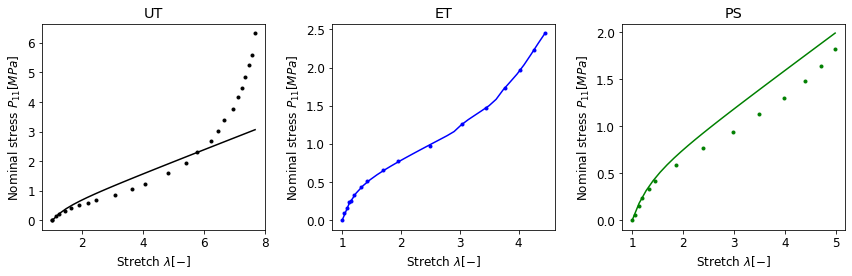

In [14]:
## Generate the output of all 3 tests
fig,axs = plt.subplots(1,3,figsize=(12,4))

lamUT_vec = np.linspace(1,UTdata['F11'].iloc[-1],30)
lamET_vec = np.linspace(1,ETdata['F11'].iloc[-1],30)
lamPS_vec = np.linspace(1,PSdata['F11'].iloc[-1],30)

normalization = [I1_factor,I2_factor,Psi1_factor,Psi2_factor ]
model = ICNN_model(params_icnn_ET[0], params_icnn_ET[1], normalization)
P11_NN_UT_p = P11_UT(lamUT_vec, model, normalization)
P11_NN_ET_p = P11_ET(lamET_vec, model, normalization)
P11_NN_PS_p = P11_PS(lamPS_vec, model, normalization) 

axs[0].plot(UTdata['F11'],UTdata['P11'] , 'k.')
axs[0].plot(lamUT_vec, P11_NN_UT_p, 'k',label='UT')

axs[1].plot(ETdata['F11'],ETdata['P11'] , 'b.')
axs[1].plot(lamET_vec, P11_NN_ET_p, 'b',label='ET')

axs[2].plot(PSdata['F11'],PSdata['P11'] , 'g.')
axs[2].plot(lamPS_vec, P11_NN_PS_p, 'g',label='PS')

#axs[0].legend(loc=2)
axs[0].set_title('UT')
axs[0].set_xlabel(r'Stretch $\lambda [-]$')
axs[0].set_ylabel(r'Nominal stress $P_{11} [MPa]$')

axs[1].set_title('ET')
axs[1].set_xlabel(r'Stretch $\lambda [-]$')
axs[1].set_ylabel(r'Nominal stress $P_{11} [MPa]$')

axs[2].set_title('PS')
axs[2].set_xlabel(r'Stretch $\lambda [-]$')
axs[2].set_ylabel(r'Nominal stress $P_{11} [MPa]$')
plt.tight_layout()

In [16]:
# save the result with pickle
with open('ICNN_params_ET.npy', 'wb') as f:
    pickle.dump(params_icnn_ET, f)

In [17]:
# train with equibiaxial only
layers = [1, 5, 5, 1]
params_I1 = init_params_icnn(layers, key)
params_I2 = init_params_icnn(layers, key)
params_icnn_PS = [params_I1,params_I2]
opt_init, opt_update, get_params = optimizers.adam(2.e-4) #Original: 1.e-4
opt_state = opt_init(params_icnn_PS)
params_icnn_PS, train_loss, val_loss = train_jp(loss_P11_PS, F11_data, opt_state, key, nIter = 100000) #Original 100000

it 1000, train loss = 9.772099e-01
it 2000, train loss = 9.352289e-01
it 3000, train loss = 8.702058e-01
it 4000, train loss = 7.670518e-01
it 5000, train loss = 6.081238e-01
it 6000, train loss = 3.846043e-01
it 7000, train loss = 1.426664e-01
it 8000, train loss = 1.447208e-02
it 9000, train loss = 1.719130e-03
it 10000, train loss = 1.663148e-03
it 11000, train loss = 1.661811e-03
it 12000, train loss = 1.659672e-03
it 13000, train loss = 1.656312e-03
it 14000, train loss = 1.651223e-03
it 15000, train loss = 1.643991e-03
it 16000, train loss = 1.634664e-03
it 17000, train loss = 1.623661e-03
it 18000, train loss = 1.609913e-03
it 19000, train loss = 1.588441e-03
it 20000, train loss = 1.551278e-03
it 21000, train loss = 1.489863e-03
it 22000, train loss = 1.395982e-03
it 23000, train loss = 1.278540e-03
it 24000, train loss = 1.186061e-03
it 25000, train loss = 1.117954e-03
it 26000, train loss = 1.062903e-03
it 27000, train loss = 1.015179e-03
it 28000, train loss = 9.713306e-04
i

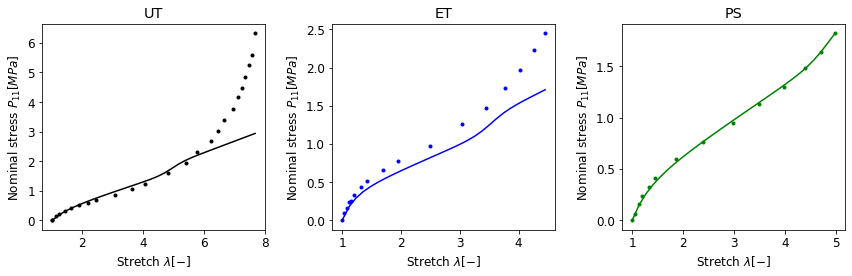

In [18]:
## Generate the output of all 3 tests
fig,axs = plt.subplots(1,3,figsize=(12,4))

lamUT_vec = np.linspace(1,UTdata['F11'].iloc[-1],30)
lamET_vec = np.linspace(1,ETdata['F11'].iloc[-1],30)
lamPS_vec = np.linspace(1,PSdata['F11'].iloc[-1],30)

normalization = [I1_factor,I2_factor,Psi1_factor,Psi2_factor ]
model = ICNN_model(params_icnn_PS[0], params_icnn_PS[1], normalization)
P11_NN_UT_p = P11_UT(lamUT_vec, model, normalization)
P11_NN_ET_p = P11_ET(lamET_vec, model, normalization)
P11_NN_PS_p = P11_PS(lamPS_vec, model, normalization) 

axs[0].plot(UTdata['F11'],UTdata['P11'] , 'k.')
axs[0].plot(lamUT_vec, P11_NN_UT_p, 'k',label='UT')

axs[1].plot(ETdata['F11'],ETdata['P11'] , 'b.')
axs[1].plot(lamET_vec, P11_NN_ET_p, 'b',label='ET')

axs[2].plot(PSdata['F11'],PSdata['P11'] , 'g.')
axs[2].plot(lamPS_vec, P11_NN_PS_p, 'g',label='PS')

#axs[0].legend(loc=2)
axs[0].set_title('UT')
axs[0].set_xlabel(r'Stretch $\lambda [-]$')
axs[0].set_ylabel(r'Nominal stress $P_{11} [MPa]$')

axs[1].set_title('ET')
axs[1].set_xlabel(r'Stretch $\lambda [-]$')
axs[1].set_ylabel(r'Nominal stress $P_{11} [MPa]$')

axs[2].set_title('PS')
axs[2].set_xlabel(r'Stretch $\lambda [-]$')
axs[2].set_ylabel(r'Nominal stress $P_{11} [MPa]$')
plt.tight_layout()

In [19]:
# save the result with pickle
with open('ICNN_params_PS.npy', 'wb') as f:
    pickle.dump(params_icnn_PS, f)

## Train CANN model

My implementation with jax because I dont know Ellen and Kevin's implementation

In [8]:
class CANN_model():
    def __init__(self, params_I1, params_I2,normalization):
        self.params_I1 = params_I1
        self.params_I2 = params_I2
        self.normalization = normalization
    # Psi1
    def Psi1norm(self, I1norm):
        # Note: I1norm = (I1-3)/normalization
        return CANN_dpsidInorm(I1norm,self.params_I1)[:,0]/normalization[0]
    # Psi2
    def Psi2norm(self, I2norm):
        # Note: I2norm = (I2-3)/normalization
        return CANN_dpsidInorm(I2norm,self.params_I2)[:,0]/normalization[1]

In [8]:
Ws = init_params_cann(key)
print(Ws)
CANN_dpsidInorm(np.linspace(0,1,10),Ws)

[DeviceArray([[-1.03109885],
             [-1.44747895],
             [-1.00712196]], dtype=float64), DeviceArray([[ 0.65888674],
             [-0.00285323],
             [-0.5234887 ]], dtype=float64), DeviceArray([[ 0.82631316],
             [ 0.22088288],
             [-0.40382857]], dtype=float64), DeviceArray([[ 0.89467568],
             [ 0.83320087],
             [-1.23863621]], dtype=float64)]


DeviceArray([[1.07342038],
             [1.13501483],
             [1.24102992],
             [1.39239202],
             [1.59147988],
             [1.84296988],
             [2.15491052],
             [2.54022908],
             [3.01899575],
             [3.62197818]], dtype=float64)

In [9]:

params_cann_I1 = init_params_cann(key)
params_cann_I2 = init_params_cann(key)
model_cann = CANN_model(params_cann_I1,params_cann_I2,normalization)
check1_cann = model_cann.Psi1norm(np.linspace(0,1,10))
check2_cann = model_cann.Psi1norm(np.linspace(0,1,10))
print(check1_cann)
#print(check2_cann)
# compare against what the NODE would give you
layers = [1, 5, 5, 1]
params_node_I1 = init_params(layers, key)
params_node_I2 = init_params(layers, key)
model_node = NODE_model(params_node_I1,params_node_I2)
check1_node = model_node.Psi1norm(np.linspace(0,1,10))
check2_node = model_node.Psi1norm(np.linspace(0,1,10))
print(check1_node)



[0.03578068 0.03783383 0.04136766 0.04641307 0.05304933 0.06143233
 0.07183035 0.0846743  0.10063319 0.12073261]
[0.         0.12643964 0.25193243 0.37577179 0.4976011  0.61737672
 0.73525866 0.85150263 0.96638578 1.08016679]


In [12]:
params_cann_I1 = init_params_cann(key)
params_cann_I2 = init_params_cann(key)
params_cann_all = [params_cann_I1,params_cann_I2]
opt_init, opt_update, get_params = optimizers.adam(2.e-4) #Original: 1.e-4
opt_state = opt_init(params_cann_all)
params_cann_all, train_loss, val_loss = train_jp(loss_P11_all, F11_data, opt_state, key, nIter = 50000) #Original 100000

it 1000, train loss = 1.838710e+00
it 2000, train loss = 6.392310e-01
it 3000, train loss = 3.274391e-01
it 4000, train loss = 1.530551e-01
it 5000, train loss = 8.352629e-02
it 6000, train loss = 5.757442e-02
it 7000, train loss = 3.271989e-02
it 8000, train loss = 2.442435e-02
it 9000, train loss = 2.226025e-02
it 10000, train loss = 2.057988e-02
it 11000, train loss = 1.909752e-02
it 12000, train loss = 1.778828e-02
it 13000, train loss = 1.641746e-02
it 14000, train loss = 1.513455e-02
it 15000, train loss = 1.413066e-02
it 16000, train loss = 1.329264e-02
it 17000, train loss = 1.250636e-02
it 18000, train loss = 1.174496e-02
it 19000, train loss = 1.103078e-02
it 20000, train loss = 1.042992e-02
it 21000, train loss = 1.002772e-02
it 22000, train loss = 9.812782e-03
it 23000, train loss = 9.693520e-03
it 24000, train loss = 9.618108e-03
it 25000, train loss = 9.566950e-03
it 26000, train loss = 9.531330e-03
it 27000, train loss = 9.506506e-03
it 28000, train loss = 9.489355e-03
i

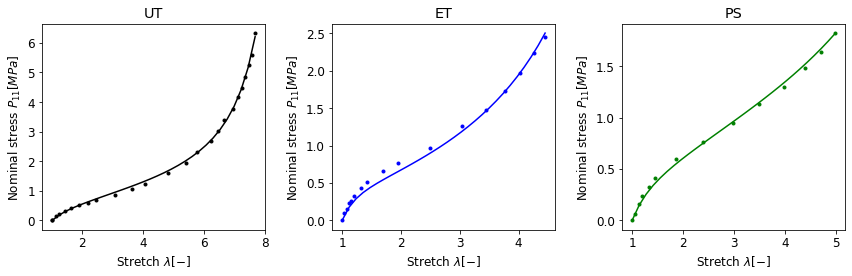

In [13]:
## Generate the output of all 3 tests
fig,axs = plt.subplots(1,3,figsize=(12,4))

lamUT_vec = np.linspace(1,UTdata['F11'].iloc[-1],30)
lamET_vec = np.linspace(1,ETdata['F11'].iloc[-1],30)
lamPS_vec = np.linspace(1,PSdata['F11'].iloc[-1],30)

normalization = [I1_factor,I2_factor,Psi1_factor,Psi2_factor ]
model = CANN_model(params_cann_all[0], params_cann_all[1], normalization)
P11_NN_UT_p = P11_UT(lamUT_vec, model, normalization)
P11_NN_ET_p = P11_ET(lamET_vec, model, normalization)
P11_NN_PS_p = P11_PS(lamPS_vec, model, normalization) 

axs[0].plot(UTdata['F11'],UTdata['P11'] , 'k.')
axs[0].plot(lamUT_vec, P11_NN_UT_p, 'k',label='UT')

axs[1].plot(ETdata['F11'],ETdata['P11'] , 'b.')
axs[1].plot(lamET_vec, P11_NN_ET_p, 'b',label='ET')

axs[2].plot(PSdata['F11'],PSdata['P11'] , 'g.')
axs[2].plot(lamPS_vec, P11_NN_PS_p, 'g',label='PS')

#axs[0].legend(loc=2)
axs[0].set_title('UT')
axs[0].set_xlabel(r'Stretch $\lambda [-]$')
axs[0].set_ylabel(r'Nominal stress $P_{11} [MPa]$')

axs[1].set_title('ET')
axs[1].set_xlabel(r'Stretch $\lambda [-]$')
axs[1].set_ylabel(r'Nominal stress $P_{11} [MPa]$')

axs[2].set_title('PS')
axs[2].set_xlabel(r'Stretch $\lambda [-]$')
axs[2].set_ylabel(r'Nominal stress $P_{11} [MPa]$')
plt.tight_layout()

In [14]:
# save the result with pickle
with open('CANN_params_all.npy', 'wb') as f:
    pickle.dump(params_cann_all, f)

In [22]:
params_cann_I1 = init_params_cann(key)
params_cann_I2 = init_params_cann(key)
params_cann_UT = [params_cann_I1,params_cann_I2]
opt_init, opt_update, get_params = optimizers.adam(2.e-4) #Original: 1.e-4
opt_state = opt_init(params_cann_UT)
params_cann_UT, train_loss, val_loss = train_jp(loss_P11_UT, F11_data, opt_state, key, nIter = 100000) #Original 100000

it 1000, train loss = 7.483079e-01
it 2000, train loss = 1.909455e-01
it 3000, train loss = 8.841627e-02
it 4000, train loss = 4.341387e-02
it 5000, train loss = 2.375478e-02
it 6000, train loss = 1.359268e-02
it 7000, train loss = 5.915429e-03
it 8000, train loss = 3.914209e-03
it 9000, train loss = 3.765410e-03
it 10000, train loss = 3.728367e-03
it 11000, train loss = 3.679444e-03
it 12000, train loss = 3.617603e-03
it 13000, train loss = 3.542624e-03
it 14000, train loss = 3.453405e-03
it 15000, train loss = 3.360052e-03
it 16000, train loss = 3.267189e-03
it 17000, train loss = 3.153184e-03
it 18000, train loss = 3.005138e-03
it 19000, train loss = 2.841556e-03
it 20000, train loss = 2.710716e-03
it 21000, train loss = 2.659024e-03
it 22000, train loss = 2.639638e-03
it 23000, train loss = 2.622491e-03
it 24000, train loss = 2.604770e-03
it 25000, train loss = 2.586047e-03
it 26000, train loss = 2.566070e-03
it 27000, train loss = 2.544606e-03
it 28000, train loss = 2.521504e-03
i

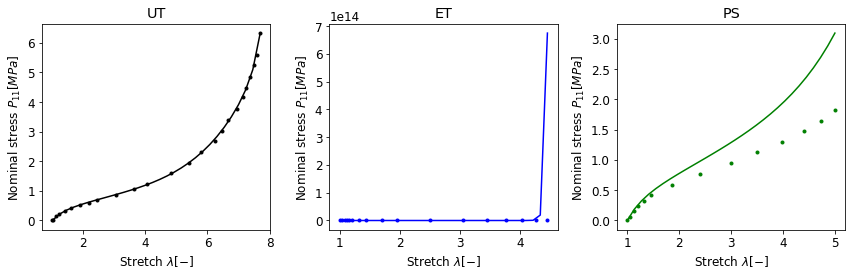

In [23]:
## Generate the output of all 3 tests
fig,axs = plt.subplots(1,3,figsize=(12,4))

lamUT_vec = np.linspace(1,UTdata['F11'].iloc[-1],30)
lamET_vec = np.linspace(1,ETdata['F11'].iloc[-1],30)
lamPS_vec = np.linspace(1,PSdata['F11'].iloc[-1],30)

normalization = [I1_factor,I2_factor,Psi1_factor,Psi2_factor ]
model = CANN_model(params_cann_UT[0], params_cann_UT[1], normalization)
P11_NN_UT_p = P11_UT(lamUT_vec, model, normalization)
P11_NN_ET_p = P11_ET(lamET_vec, model, normalization)
P11_NN_PS_p = P11_PS(lamPS_vec, model, normalization) 

axs[0].plot(UTdata['F11'],UTdata['P11'] , 'k.')
axs[0].plot(lamUT_vec, P11_NN_UT_p, 'k',label='UT')

axs[1].plot(ETdata['F11'],ETdata['P11'] , 'b.')
axs[1].plot(lamET_vec, P11_NN_ET_p, 'b',label='ET')

axs[2].plot(PSdata['F11'],PSdata['P11'] , 'g.')
axs[2].plot(lamPS_vec, P11_NN_PS_p, 'g',label='PS')

#axs[0].legend(loc=2)
axs[0].set_title('UT')
axs[0].set_xlabel(r'Stretch $\lambda [-]$')
axs[0].set_ylabel(r'Nominal stress $P_{11} [MPa]$')

axs[1].set_title('ET')
axs[1].set_xlabel(r'Stretch $\lambda [-]$')
axs[1].set_ylabel(r'Nominal stress $P_{11} [MPa]$')

axs[2].set_title('PS')
axs[2].set_xlabel(r'Stretch $\lambda [-]$')
axs[2].set_ylabel(r'Nominal stress $P_{11} [MPa]$')
plt.tight_layout()

In [25]:
# save the result with pickle
with open('CANN_params_UT.npy', 'wb') as f:
    pickle.dump(params_cann_UT, f)

In [26]:
params_cann_I1 = init_params_cann(key)
params_cann_I2 = init_params_cann(key)
params_cann_ET = [params_cann_I1,params_cann_I2]
opt_init, opt_update, get_params = optimizers.adam(2.e-4) #Original: 1.e-4
opt_state = opt_init(params_cann_ET)
params_cann_ET, train_loss, val_loss = train_jp(loss_P11_ET, F11_data, opt_state, key, nIter = 100000) #Original 100000

it 1000, train loss = 3.788936e-01
it 2000, train loss = 1.795112e-01
it 3000, train loss = 1.046822e-01
it 4000, train loss = 5.730773e-02
it 5000, train loss = 2.356473e-02
it 6000, train loss = 6.311977e-03
it 7000, train loss = 1.451495e-03
it 8000, train loss = 8.159658e-04
it 9000, train loss = 7.160118e-04
it 10000, train loss = 6.106633e-04
it 11000, train loss = 4.955796e-04
it 12000, train loss = 4.105695e-04
it 13000, train loss = 3.715434e-04
it 14000, train loss = 3.492045e-04
it 15000, train loss = 3.223811e-04
it 16000, train loss = 2.933607e-04
it 17000, train loss = 2.731509e-04
it 18000, train loss = 2.602983e-04
it 19000, train loss = 2.502127e-04
it 20000, train loss = 2.416344e-04
it 21000, train loss = 2.352398e-04
it 22000, train loss = 2.299557e-04
it 23000, train loss = 2.243505e-04
it 24000, train loss = 2.179743e-04
it 25000, train loss = 2.109790e-04
it 26000, train loss = 2.050132e-04
it 27000, train loss = 2.022445e-04
it 28000, train loss = 2.012927e-04
i

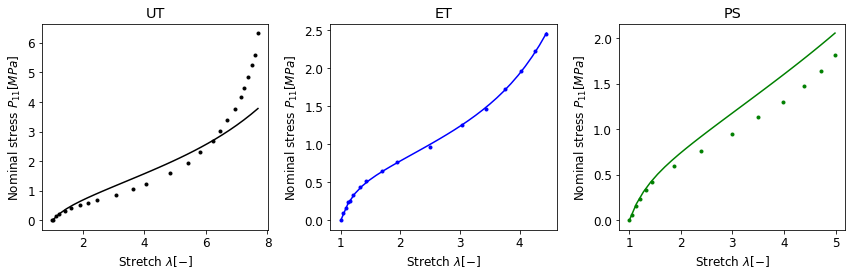

In [28]:
## Generate the output of all 3 tests
fig,axs = plt.subplots(1,3,figsize=(12,4))

lamUT_vec = np.linspace(1,UTdata['F11'].iloc[-1],30)
lamET_vec = np.linspace(1,ETdata['F11'].iloc[-1],30)
lamPS_vec = np.linspace(1,PSdata['F11'].iloc[-1],30)

normalization = [I1_factor,I2_factor,Psi1_factor,Psi2_factor ]
model = CANN_model(params_cann_ET[0], params_cann_ET[1], normalization)
P11_NN_UT_p = P11_UT(lamUT_vec, model, normalization)
P11_NN_ET_p = P11_ET(lamET_vec, model, normalization)
P11_NN_PS_p = P11_PS(lamPS_vec, model, normalization) 

axs[0].plot(UTdata['F11'],UTdata['P11'] , 'k.')
axs[0].plot(lamUT_vec, P11_NN_UT_p, 'k',label='UT')

axs[1].plot(ETdata['F11'],ETdata['P11'] , 'b.')
axs[1].plot(lamET_vec, P11_NN_ET_p, 'b',label='ET')

axs[2].plot(PSdata['F11'],PSdata['P11'] , 'g.')
axs[2].plot(lamPS_vec, P11_NN_PS_p, 'g',label='PS')

#axs[0].legend(loc=2)
axs[0].set_title('UT')
axs[0].set_xlabel(r'Stretch $\lambda [-]$')
axs[0].set_ylabel(r'Nominal stress $P_{11} [MPa]$')

axs[1].set_title('ET')
axs[1].set_xlabel(r'Stretch $\lambda [-]$')
axs[1].set_ylabel(r'Nominal stress $P_{11} [MPa]$')

axs[2].set_title('PS')
axs[2].set_xlabel(r'Stretch $\lambda [-]$')
axs[2].set_ylabel(r'Nominal stress $P_{11} [MPa]$')
plt.tight_layout()

In [29]:
# save the result with pickle
with open('CANN_params_ET.npy', 'wb') as f:
    pickle.dump(params_cann_ET, f)

In [31]:
params_cann_I1 = init_params_cann(key)
params_cann_I2 = init_params_cann(key)
params_cann_PS = [params_cann_I1,params_cann_I2]
opt_init, opt_update, get_params = optimizers.adam(2.e-4) #Original: 1.e-4
opt_state = opt_init(params_cann_PS)
params_cann_PS, train_loss, val_loss = train_jp(loss_P11_PS, F11_data, opt_state, key, nIter = 100000) #Original 100000

it 1000, train loss = 4.092177e-01
it 2000, train loss = 9.661326e-02
it 3000, train loss = 6.503183e-02
it 4000, train loss = 4.197584e-02
it 5000, train loss = 2.164836e-02
it 6000, train loss = 8.797436e-03
it 7000, train loss = 3.415459e-03
it 8000, train loss = 1.684836e-03
it 9000, train loss = 1.175324e-03
it 10000, train loss = 1.034113e-03
it 11000, train loss = 9.890816e-04
it 12000, train loss = 9.513068e-04
it 13000, train loss = 8.986528e-04
it 14000, train loss = 8.404377e-04
it 15000, train loss = 7.930430e-04
it 16000, train loss = 7.575525e-04
it 17000, train loss = 7.242873e-04
it 18000, train loss = 6.840936e-04
it 19000, train loss = 6.362252e-04
it 20000, train loss = 5.913434e-04
it 21000, train loss = 5.597318e-04
it 22000, train loss = 5.414504e-04
it 23000, train loss = 5.325205e-04
it 24000, train loss = 5.291541e-04
it 25000, train loss = 5.283577e-04
it 26000, train loss = 5.282727e-04
it 27000, train loss = 5.282668e-04
it 28000, train loss = 5.282650e-04
i

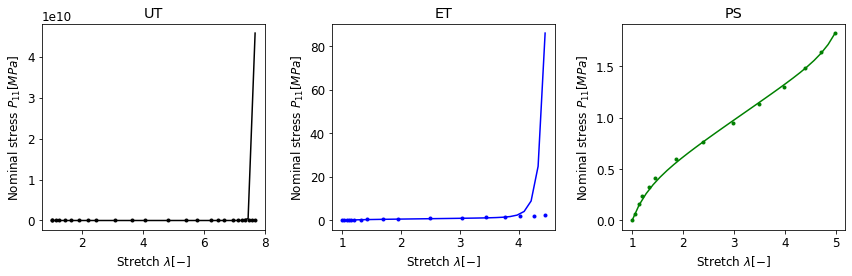

In [32]:
fig,axs = plt.subplots(1,3,figsize=(12,4))

lamUT_vec = np.linspace(1,UTdata['F11'].iloc[-1],30)
lamET_vec = np.linspace(1,ETdata['F11'].iloc[-1],30)
lamPS_vec = np.linspace(1,PSdata['F11'].iloc[-1],30)

normalization = [I1_factor,I2_factor,Psi1_factor,Psi2_factor ]
model = CANN_model(params_cann_PS[0], params_cann_PS[1], normalization)
P11_NN_UT_p = P11_UT(lamUT_vec, model, normalization)
P11_NN_ET_p = P11_ET(lamET_vec, model, normalization)
P11_NN_PS_p = P11_PS(lamPS_vec, model, normalization) 

axs[0].plot(UTdata['F11'],UTdata['P11'] , 'k.')
axs[0].plot(lamUT_vec, P11_NN_UT_p, 'k',label='UT')

axs[1].plot(ETdata['F11'],ETdata['P11'] , 'b.')
axs[1].plot(lamET_vec, P11_NN_ET_p, 'b',label='ET')

axs[2].plot(PSdata['F11'],PSdata['P11'] , 'g.')
axs[2].plot(lamPS_vec, P11_NN_PS_p, 'g',label='PS')

#axs[0].legend(loc=2)
axs[0].set_title('UT')
axs[0].set_xlabel(r'Stretch $\lambda [-]$')
axs[0].set_ylabel(r'Nominal stress $P_{11} [MPa]$')

axs[1].set_title('ET')
axs[1].set_xlabel(r'Stretch $\lambda [-]$')
axs[1].set_ylabel(r'Nominal stress $P_{11} [MPa]$')

axs[2].set_title('PS')
axs[2].set_xlabel(r'Stretch $\lambda [-]$')
axs[2].set_ylabel(r'Nominal stress $P_{11} [MPa]$')
plt.tight_layout()

In [33]:
with open('CANN_params_PS.npy', 'wb') as f:
    pickle.dump(params_cann_PS, f)

## PLOT ALL RESULTS

In [9]:
# ALL
with open('model_params/NODE_params_all.npy', 'rb') as f:
    params_node_all = pickle.load(f)
with open('model_params/ICNN_params_all.npy', 'rb') as f:
    params_icnn_all = pickle.load(f)
with open('model_params/CANN_params_all.npy', 'rb') as f:
    params_cann_all = pickle.load(f)

# UT
with open('model_params/NODE_params_UT.npy', 'rb') as f:
    params_node_UT = pickle.load(f)
with open('model_params/ICNN_params_UT.npy', 'rb') as f:
    params_icnn_UT = pickle.load(f)
with open('model_params/CANN_params_UT.npy', 'rb') as f:
    params_cann_UT = pickle.load(f)

# ET
with open('model_params/NODE_params_ET.npy', 'rb') as f:
    params_node_ET = pickle.load(f)
with open('model_params/ICNN_params_ET.npy', 'rb') as f:
    params_icnn_ET = pickle.load(f)
with open('model_params/CANN_params_ET.npy', 'rb') as f:
    params_cann_ET = pickle.load(f)

# PS
with open('model_params/NODE_params_PS.npy', 'rb') as f:
    params_node_PS = pickle.load(f)
with open('model_params/ICNN_params_PS.npy', 'rb') as f:
    params_icnn_PS = pickle.load(f)
with open('model_params/CANN_params_PS.npy', 'rb') as f:
    params_cann_PS = pickle.load(f)



In [ ]:
import pandas as pd
header = ['x', 'y_gt', 'y_node', 'y_cann', 'y_icnn']

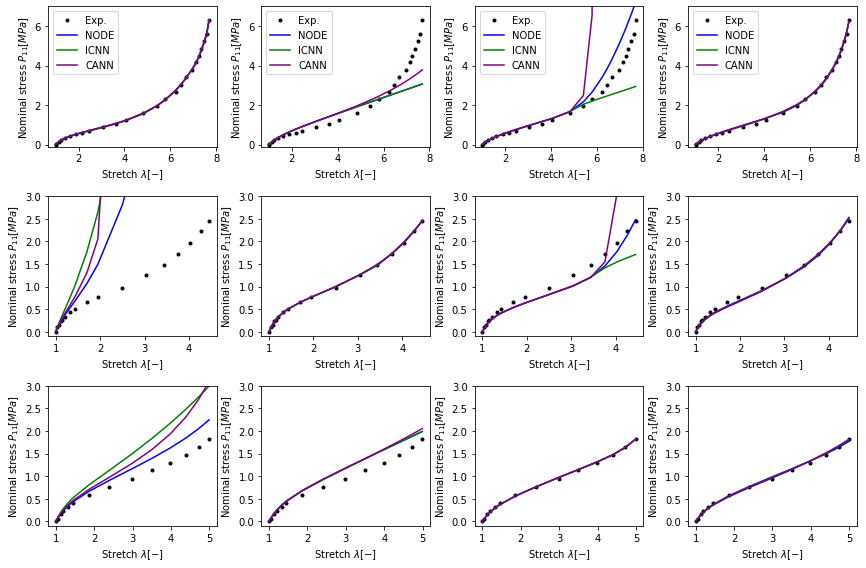

In [27]:
fig,axs = plt.subplots(3,4,figsize=(12,8))

# lamUT_vec = np.linspace(1,UTdata['F11'].iloc[-1],30)
# lamET_vec = np.linspace(1,ETdata['F11'].iloc[-1],30)
# lamPS_vec = np.linspace(1,PSdata['F11'].iloc[-1],30)
lamUT_vec = np.array(UTdata['F11'])
lamET_vec = np.array(ETdata['F11'])
lamPS_vec = np.array(PSdata['F11'])

normalization = [I1_factor,I2_factor,Psi1_factor,Psi2_factor ]

for i in range(4):
    axs[0,i].plot(UTdata['F11'],UTdata['P11'] , 'k.',label='Exp.')
    axs[1,i].plot(ETdata['F11'],ETdata['P11'] , 'k.',label='Exp.')
    axs[2,i].plot(PSdata['F11'],PSdata['P11'] , 'k.',label='Exp.')

## UT only
# NODE
model = NODE_model(params_node_UT[0], params_node_UT[1])
P11_node_UT = P11_UT(lamUT_vec, model, normalization)
P11_node_ET = P11_ET(lamET_vec, model, normalization)
P11_node_PS = P11_PS(lamPS_vec, model, normalization) 
axs[0,0].plot(lamUT_vec, P11_node_UT, 'b',label='NODE')
axs[1,0].plot(lamET_vec, P11_node_ET, 'b',label='NODE')
axs[2,0].plot(lamPS_vec, P11_node_PS, 'b',label='NODE')
# ICNN
model = ICNN_model(params_icnn_UT[0], params_icnn_UT[1],normalization)
P11_icnn_UT = P11_UT(lamUT_vec, model, normalization)
P11_icnn_ET = P11_ET(lamET_vec, model, normalization)
P11_icnn_PS = P11_PS(lamPS_vec, model, normalization) 
axs[0,0].plot(lamUT_vec, P11_icnn_UT, 'g',label='ICNN')
axs[1,0].plot(lamET_vec, P11_icnn_ET, 'g',label='ICNN')
axs[2,0].plot(lamPS_vec, P11_icnn_PS, 'g',label='ICNN')
# CANN
model = CANN_model(params_cann_UT[0], params_cann_UT[1],normalization)
P11_cann_UT = P11_UT(lamUT_vec, model, normalization)
P11_cann_ET = P11_ET(lamET_vec, model, normalization)
P11_cann_PS = P11_PS(lamPS_vec, model, normalization) 
axs[0,0].plot(lamUT_vec, P11_cann_UT, color='purple',label='CANN')
axs[1,0].plot(lamET_vec, P11_cann_ET, color='purple',label='CANN')
axs[2,0].plot(lamPS_vec, P11_cann_PS, color='purple',label='CANN')

# Save for TikZ
P11_node_UT = np.clip(P11_node_UT, a_min = -100, a_max = 100)
P11_node_ET = np.clip(P11_node_ET, a_min = -100, a_max = 100)
P11_node_PS = np.clip(P11_node_PS, a_min = -100, a_max = 100)
P11_cann_UT = np.clip(P11_cann_UT, a_min = -100, a_max = 100)
P11_cann_ET = np.clip(P11_cann_ET, a_min = -100, a_max = 100)
P11_cann_PS = np.clip(P11_cann_PS, a_min = -100, a_max = 100)
P11_icnn_UT = np.clip(P11_icnn_UT, a_min = -100, a_max = 100)
P11_icnn_ET = np.clip(P11_icnn_ET, a_min = -100, a_max = 100)
P11_icnn_PS = np.clip(P11_icnn_PS, a_min = -100, a_max = 100)
data = np.array([lamUT_vec, UTdata['P11'], P11_node_UT, P11_cann_UT, P11_icnn_UT]).T
df = pd.DataFrame(data, columns = header)
df.to_csv('TikZ_data/fig_rubber_a.csv', index=False, sep=' ')
data = np.array([lamET_vec, ETdata['P11'], P11_node_ET, P11_cann_ET, P11_icnn_ET]).T
df = pd.DataFrame(data, columns = header)
df.to_csv('TikZ_data/fig_rubber_e.csv', index=False, sep=' ')
data = np.array([lamPS_vec, PSdata['P11'], P11_node_PS, P11_cann_PS, P11_icnn_PS]).T
df = pd.DataFrame(data, columns = header)
df.to_csv('TikZ_data/fig_rubber_i.csv', index=False, sep=' ')

## ET only
# NODE
model = NODE_model(params_node_ET[0], params_node_ET[1])
P11_node_UT = P11_UT(lamUT_vec, model, normalization)
P11_node_ET = P11_ET(lamET_vec, model, normalization)
P11_node_PS = P11_PS(lamPS_vec, model, normalization) 
axs[0,1].plot(lamUT_vec, P11_node_UT, 'b',label='NODE')
axs[1,1].plot(lamET_vec, P11_node_ET, 'b',label='NODE')
axs[2,1].plot(lamPS_vec, P11_node_PS, 'b',label='NODE')
# ICNN
model = ICNN_model(params_icnn_ET[0], params_icnn_ET[1],normalization)
P11_icnn_UT = P11_UT(lamUT_vec, model, normalization)
P11_icnn_ET = P11_ET(lamET_vec, model, normalization)
P11_icnn_PS = P11_PS(lamPS_vec, model, normalization) 
axs[0,1].plot(lamUT_vec, P11_icnn_UT, 'g',label='ICNN')
axs[1,1].plot(lamET_vec, P11_icnn_ET, 'g',label='ICNN')
axs[2,1].plot(lamPS_vec, P11_icnn_PS, 'g',label='ICNN')
# CANN
model = CANN_model(params_cann_ET[0], params_cann_ET[1],normalization)
P11_cann_UT = P11_UT(lamUT_vec, model, normalization)
P11_cann_ET = P11_ET(lamET_vec, model, normalization)
P11_cann_PS = P11_PS(lamPS_vec, model, normalization) 
axs[0,1].plot(lamUT_vec, P11_cann_UT, color='purple',label='CANN')
axs[1,1].plot(lamET_vec, P11_cann_ET, color='purple',label='CANN')
axs[2,1].plot(lamPS_vec, P11_cann_PS, color='purple',label='CANN')

# Save for TikZ
P11_node_UT = np.clip(P11_node_UT, a_min = -100, a_max = 100)
P11_node_ET = np.clip(P11_node_ET, a_min = -100, a_max = 100)
P11_node_PS = np.clip(P11_node_PS, a_min = -100, a_max = 100)
P11_cann_UT = np.clip(P11_cann_UT, a_min = -100, a_max = 100)
P11_cann_ET = np.clip(P11_cann_ET, a_min = -100, a_max = 100)
P11_cann_PS = np.clip(P11_cann_PS, a_min = -100, a_max = 100)
P11_icnn_UT = np.clip(P11_icnn_UT, a_min = -100, a_max = 100)
P11_icnn_ET = np.clip(P11_icnn_ET, a_min = -100, a_max = 100)
P11_icnn_PS = np.clip(P11_icnn_PS, a_min = -100, a_max = 100)
data = np.array([lamUT_vec, UTdata['P11'], P11_node_UT, P11_cann_UT, P11_icnn_UT]).T
df = pd.DataFrame(data, columns = header)
df.to_csv('TikZ_data/fig_rubber_b.csv', index=False, sep=' ')
data = np.array([lamET_vec, ETdata['P11'], P11_node_ET, P11_cann_ET, P11_icnn_ET]).T
df = pd.DataFrame(data, columns = header)
df.to_csv('TikZ_data/fig_rubber_f.csv', index=False, sep=' ')
data = np.array([lamPS_vec, PSdata['P11'], P11_node_PS, P11_cann_PS, P11_icnn_PS]).T
df = pd.DataFrame(data, columns = header)
df.to_csv('TikZ_data/fig_rubber_j.csv', index=False, sep=' ')

## PS only
# NODE
model = NODE_model(params_node_PS[0], params_node_PS[1])
P11_node_UT = P11_UT(lamUT_vec, model, normalization)
P11_node_ET = P11_ET(lamET_vec, model, normalization)
P11_node_PS = P11_PS(lamPS_vec, model, normalization) 
axs[0,2].plot(lamUT_vec, P11_node_UT, 'b',label='NODE')
axs[1,2].plot(lamET_vec, P11_node_ET, 'b',label='NODE')
axs[2,2].plot(lamPS_vec, P11_node_PS, 'b',label='NODE')
# ICNN
model = ICNN_model(params_icnn_PS[0], params_icnn_PS[1],normalization)
P11_icnn_UT = P11_UT(lamUT_vec, model, normalization)
P11_icnn_ET = P11_ET(lamET_vec, model, normalization)
P11_icnn_PS = P11_PS(lamPS_vec, model, normalization) 
axs[0,2].plot(lamUT_vec, P11_icnn_UT, 'g',label='ICNN')
axs[1,2].plot(lamET_vec, P11_icnn_ET, 'g',label='ICNN')
axs[2,2].plot(lamPS_vec, P11_icnn_PS, 'g',label='ICNN')
# CANN
model = CANN_model(params_cann_PS[0], params_cann_PS[1],normalization)
P11_cann_UT = P11_UT(lamUT_vec, model, normalization)
P11_cann_ET = P11_ET(lamET_vec, model, normalization)
P11_cann_PS = P11_PS(lamPS_vec, model, normalization) 
axs[0,2].plot(lamUT_vec, P11_cann_UT, color='purple',label='CANN')
axs[1,2].plot(lamET_vec, P11_cann_ET, color='purple',label='CANN')
axs[2,2].plot(lamPS_vec, P11_cann_PS, color='purple',label='CANN')

# Save for TikZ
P11_node_UT = np.clip(P11_node_UT, a_min = -100, a_max = 100)
P11_node_ET = np.clip(P11_node_ET, a_min = -100, a_max = 100)
P11_node_PS = np.clip(P11_node_PS, a_min = -100, a_max = 100)
P11_cann_UT = np.clip(P11_cann_UT, a_min = -100, a_max = 100)
P11_cann_ET = np.clip(P11_cann_ET, a_min = -100, a_max = 100)
P11_cann_PS = np.clip(P11_cann_PS, a_min = -100, a_max = 100)
P11_icnn_UT = np.clip(P11_icnn_UT, a_min = -100, a_max = 100)
P11_icnn_ET = np.clip(P11_icnn_ET, a_min = -100, a_max = 100)
P11_icnn_PS = np.clip(P11_icnn_PS, a_min = -100, a_max = 100)
data = np.array([lamUT_vec, UTdata['P11'], P11_node_UT, P11_cann_UT, P11_icnn_UT]).T
df = pd.DataFrame(data, columns = header)
df.to_csv('TikZ_data/fig_rubber_c.csv', index=False, sep=' ')
data = np.array([lamET_vec, ETdata['P11'], P11_node_ET, P11_cann_ET, P11_icnn_ET]).T
df = pd.DataFrame(data, columns = header)
df.to_csv('TikZ_data/fig_rubber_g.csv', index=False, sep=' ')
data = np.array([lamPS_vec, PSdata['P11'], P11_node_PS, P11_cann_PS, P11_icnn_PS]).T
df = pd.DataFrame(data, columns = header)
df.to_csv('TikZ_data/fig_rubber_k.csv', index=False, sep=' ')

## All
# NODE
model = NODE_model(params_node_all[0], params_node_all[1])
P11_node_UT = P11_UT(lamUT_vec, model, normalization)
P11_node_ET = P11_ET(lamET_vec, model, normalization)
P11_node_PS = P11_PS(lamPS_vec, model, normalization) 
axs[0,3].plot(lamUT_vec, P11_node_UT, 'b',label='NODE')
axs[1,3].plot(lamET_vec, P11_node_ET, 'b',label='NODE')
axs[2,3].plot(lamPS_vec, P11_node_PS, 'b',label='NODE')
# ICNN
model = ICNN_model(params_icnn_all[0], params_icnn_all[1],normalization)
P11_icnn_UT = P11_UT(lamUT_vec, model, normalization)
P11_icnn_ET = P11_ET(lamET_vec, model, normalization)
P11_icnn_PS = P11_PS(lamPS_vec, model, normalization) 
axs[0,3].plot(lamUT_vec, P11_icnn_UT, 'g',label='ICNN')
axs[1,3].plot(lamET_vec, P11_icnn_ET, 'g',label='ICNN')
axs[2,3].plot(lamPS_vec, P11_icnn_PS, 'g',label='ICNN')
# CANN
model = CANN_model(params_cann_all[0], params_cann_all[1],normalization)
P11_cann_UT = P11_UT(lamUT_vec, model, normalization)
P11_cann_ET = P11_ET(lamET_vec, model, normalization)
P11_cann_PS = P11_PS(lamPS_vec, model, normalization) 
axs[0,3].plot(lamUT_vec, P11_cann_UT, color='purple',label='CANN')
axs[1,3].plot(lamET_vec, P11_cann_ET, color='purple',label='CANN')
axs[2,3].plot(lamPS_vec, P11_cann_PS, color='purple',label='CANN')

# Save for TikZ
P11_node_UT = np.clip(P11_node_UT, a_min = -100, a_max = 100)
P11_node_ET = np.clip(P11_node_ET, a_min = -100, a_max = 100)
P11_node_PS = np.clip(P11_node_PS, a_min = -100, a_max = 100)
P11_cann_UT = np.clip(P11_cann_UT, a_min = -100, a_max = 100)
P11_cann_ET = np.clip(P11_cann_ET, a_min = -100, a_max = 100)
P11_cann_PS = np.clip(P11_cann_PS, a_min = -100, a_max = 100)
P11_icnn_UT = np.clip(P11_icnn_UT, a_min = -100, a_max = 100)
P11_icnn_ET = np.clip(P11_icnn_ET, a_min = -100, a_max = 100)
P11_icnn_PS = np.clip(P11_icnn_PS, a_min = -100, a_max = 100)
data = np.array([lamUT_vec, UTdata['P11'], P11_node_UT, P11_cann_UT, P11_icnn_UT]).T
df = pd.DataFrame(data, columns = header)
df.to_csv('TikZ_data/fig_rubber_d.csv', index=False, sep=' ')
data = np.array([lamET_vec, ETdata['P11'], P11_node_ET, P11_cann_ET, P11_icnn_ET]).T
df = pd.DataFrame(data, columns = header)
df.to_csv('TikZ_data/fig_rubber_h.csv', index=False, sep=' ')
data = np.array([lamPS_vec, PSdata['P11'], P11_node_PS, P11_cann_PS, P11_icnn_PS]).T
df = pd.DataFrame(data, columns = header)
df.to_csv('TikZ_data/fig_rubber_l.csv', index=False, sep=' ')




# legends, annotations and limits
for i in range(4):
    axs[0,i].legend(loc=2)
    axs[0,i].set_xlabel(r'Stretch $\lambda [-]$')
    axs[0,i].set_ylabel(r'Nominal stress $P_{11} [MPa]$')
    axs[1,i].set_xlabel(r'Stretch $\lambda [-]$')
    axs[1,i].set_ylabel(r'Nominal stress $P_{11} [MPa]$')
    axs[2,i].set_xlabel(r'Stretch $\lambda [-]$')
    axs[2,i].set_ylabel(r'Nominal stress $P_{11} [MPa]$')
    axs[0,i].set_ylim([-0.1,7])
    axs[1,i].set_ylim([-0.1,3])
    axs[2,i].set_ylim([-0.1,3])

plt.tight_layout()
plt.savefig('Rubber_data_model_comparisons.png',dpi=200)